# The problem

$$
    -\kappa\Delta u + \beta\cdot u = f \quad x \in\Omega := (0,1)^2, \\
    u|_{\partial\Omega}=0.
$$
Here 
$$
    k=10^{-2}, \quad \beta = (\textstyle\frac{1}{2},1)\sqrt{\frac{4}{5}}, \quad f(x,y) =
    \begin{cases}
        +1 \text{  if  } y \ge 2x,\\
        -1 \text{  else}.
    \end{cases}
$$

https://github.com/pierremtb/PINNs-TF2.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf

In [2]:
def f(x,y):
    
    if y >= 2*x:
        return 1
    else:
        return -1
    
f = np.vectorize(f)

In [3]:
class custom_colorbar():
    """Botched custom colorbar class, needed because the standard colorbars
    didn't want to update in the animation below."""
    
    def __init__(self, ax,
                 n_colors = 100,
                 n_ticks  = 5):
        
        self.ax       = ax
        self.n_colors = n_colors
        self.n_ticks  = n_ticks
        divider       = make_axes_locatable(ax)
        self.cax      = divider.append_axes('right', size='5%', pad=0.05)
        
        self.cax.set_xticks([])
        self.cax.yaxis.tick_right()
        
    def update_data(self, data):
        
        data_min = np.min(data)
        data_max = np.max(data)
        
        self.cax.imshow(np.linspace(1,0,self.n_colors)[np.newaxis].T, extent = [data_min/20,data_max/20,data_min,data_max])
        self.cax.set_yticks(np.linspace(data_min,data_max,self.n_ticks))

# The PINN class

In [4]:
class PINN():
    
    def __init__(self,
                 optimizer,
                 hidden_layer_widths  = np.array([40,40,40]),
                 random_sampling      = True,
                 kappa                = 1e-2,
                 beta                 = np.array([0.5,1])*np.sqrt(0.8),
                 interior_grid_size   = 25,
                 samples_per_boundary = [5,5,5,5],
                 boundary_weight      = 0.5
                ):
        """Class to solve the above PDE using a physics informed
        neural network implemented in tensorflow."""
   
        # Constants
        self.kappa = kappa
        self.beta  = beta
        
        # Data type of tf computations
        self.dtype = np.float32
        
        # Sequential model
        self.model = tf.keras.Sequential()
        
        # Input layer
        self.model.add(tf.keras.layers.InputLayer(input_shape = 2))
        
        # Hidden layers
        for width in hidden_layer_widths:
            self.model.add(tf.keras.layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer = 'glorot_normal'))
            
        # Output layer
        self.model.add(tf.keras.layers.Dense(
                1, activation=tf.nn.tanh,
                kernel_initializer = 'glorot_normal'))
        
        # Optimizer
        self.optimizer = optimizer
        
        # Number of points in both dimensions in grid for residual mimimization
        self.interior_grid_size = interior_grid_size
        
        # Number of samples for each boundary individually (left,right,top,bottom)
        self.samples_per_boundary = samples_per_boundary
        
        # Whether sampling for the PINN training happens randomly or on a fixed grid
        self.random_sampling = random_sampling
        
        # Parameter to distribute weight over the boundary and interior loss
        self.boundary_weight = boundary_weight
        
        # Construct point grid for sampling and plotting
        self.construct_point_grid()
        
        
    def construct_point_grid(self):
        """ Construct a set of points in a grid, used for grid sampling and plotting."""
        
        # Construction of point grid
        self.XY_grid = np.stack(np.meshgrid(np.linspace(0,1,self.interior_grid_size),
                                            np.linspace(1,0,self.interior_grid_size))).astype(self.dtype)

        # Construct boolean array that indicates boundary
        self.boundary           = np.zeros((self.interior_grid_size,
                                            self.interior_grid_size), dtype = bool)
        self.boundary[(0,-1),:] = True
        self.boundary[:,(0,-1)] = True

        # Points in a format passable to the model
        self.interior_points_grid = self.XY_grid[:,~self.boundary].T
        
        left_boundary      = np.zeros((self.samples_per_boundary[0],2))
        left_boundary[:,1]   = np.linspace(0,1,self.samples_per_boundary[0])
        right_boundary     = np.ones((self.samples_per_boundary[1],2))
        right_boundary[:,1]  = np.linspace(0,1,self.samples_per_boundary[1])
        bottom_boundary    = np.zeros((self.samples_per_boundary[2],2))
        bottom_boundary[:,0] = np.linspace(0,1,self.samples_per_boundary[2])
        top_boundary       = np.ones((self.samples_per_boundary[3],2))
        top_boundary[:,0]   = np.linspace(0,1,self.samples_per_boundary[3])
        
        self.boundary_points_grid = np.concatenate([left_boundary,right_boundary,
                                                    bottom_boundary,top_boundary]).astype(self.dtype)
        
        # Total domain in a format passable to the model (for plotting)
        self.total_grid_domain = self.XY_grid.reshape((2,(self.interior_grid_size)**2)).T
     
    

    
    def generate_sample_points(self, max_perturbation = 0.5):
        """Generate sampling points for training, either random or in the grid."""
        
        max_perturbation /= self.interior_grid_size-1
        
        if self.random_sampling:
            
            # Generate randomly perturbed points
            interior_points = self.interior_points_grid + np.random.uniform(-max_perturbation,
                                                                             max_perturbation, 
                                                                            ((self.interior_grid_size-2)**2,2)).astype(self.dtype)
            
            self.interior_sample_points = interior_points
            self.boundary_sample_points = self.boundary_points_grid

        else:
            
            self.interior_sample_points = self.interior_points_grid
            self.boundary_sample_points = self.boundary_points_grid
                        
        
        
        
    def __loss(self):
        """Calculation of the loss for generated sample points."""
        
        self.generate_sample_points()
        interior_tensor = tf.convert_to_tensor(np.concatenate([self.interior_sample_points,
                                                               self.boundary_sample_points]))
        boundary_tensor = tf.convert_to_tensor(self.boundary_sample_points)
        
        boundary_loss = tf.reduce_mean(tf.square(self.model(boundary_tensor, training = True)))
        
        # Using GradientTape for computing the derivatives of the model output
        with tf.GradientTape(persistent=True) as tape:
            
            tape.watch(interior_tensor)
            tape.watch(boundary_tensor)
            
            u_interior = self.model(interior_tensor)
            u_boundary = self.model(boundary_tensor)
            
            grad_u_interior   = tape.gradient(u_interior, interior_tensor)
            u_interior_x      = grad_u_interior[:,0]
            u_interior_y      = grad_u_interior[:,1]
            
            u_interior_xx = tape.gradient(u_interior_x, interior_tensor)[:,0]
            u_interior_yy = tape.gradient(u_interior_y, interior_tensor)[:,1]
            
            diffusion     = tf.math.scalar_mul(-self.kappa,tf.math.add(u_interior_xx,u_interior_yy))
            advection     = tf.math.add(tf.math.scalar_mul(self.beta[0],u_interior_x),
                                        tf.math.scalar_mul(self.beta[1],u_interior_y))
            f_values      = f(interior_tensor[:,0], interior_tensor[:,1])
            
            interior_loss = tf.reduce_mean(tf.square(diffusion + advection - f_values))
        
        # Letting the tape go
        del tape
        
        self.loss     = boundary_loss + interior_loss
        self.bnd_loss = boundary_loss
        self.int_loss = interior_loss
        
        return self.boundary_weight*boundary_loss + (1-self.boundary_weight)*interior_loss
    
    
    
    
    def __grad(self):
        """Calculation of the gradient of the loss value for optimization."""
        with tf.GradientTape() as tape:
            loss_value = self.__loss()
        
        return tape.gradient(loss_value, self.model.trainable_variables)
        
        
        
        
    def fit(self, tf_epochs = 5000,
            plot_interval = 50,
            eps = 1e-6):
        """Fitting function to train the PINN. Most of the code here is for plotting."""
        
        %matplotlib notebook
        
        # Loss plotting
        fig, axs      = plt.subplots(1,2, figsize = (10,5))
        ax_loss, ax_u = axs
        losses_tot    = []
        losses_int    = []
        losses_bnd    = []
        epochs        = []
        tot_loss_line = ax_loss.plot(epochs, losses_tot, label = 'Total loss')[0]
        int_loss_line = ax_loss.plot(epochs, losses_int, label = 'Interior loss (residual)')[0]
        bnd_loss_line = ax_loss.plot(epochs, losses_bnd, label = 'Boundary loss')[0]
        
        ax_loss.legend()
        
        # Scattering of sample points
        int_sample_sc = ax_u.scatter(self.interior_points_grid[:,0], self.interior_points_grid[:,1], color = 'w',
                                     s = 1, label = 'Interior sample points of last epoch')
        bnd_sample_sc = ax_u.scatter(self.boundary_points_grid[:,0], self.boundary_points_grid[:,1], color = 'w',
                                     s = 10, label = 'Boundary sample points of last epoch', marker = 'x')
        
        ax_loss.set_yscale('log')
        ax_loss.set_xlabel('epochs')
        ax_loss.set_ylabel('loss')
        
        # u plotting
        if not hasattr(self,'total_grid_domain'):
            self.construct_point_grid()
        
        u                = np.array(self.model(self.total_grid_domain)).reshape((self.interior_grid_size,
                                                                                 self.interior_grid_size))
        half_pixel_width = 0.5/(self.interior_grid_size-1) 
        u_image = ax_u.imshow(u, extent = [-half_pixel_width,1+half_pixel_width,
                                           -half_pixel_width,1+half_pixel_width])
        
        # u colorbar
        u_colorbar = custom_colorbar(ax_u)
            
        ax_u.set_xlabel("$x$")
        ax_u.set_ylabel("$y$")
        ax_u.set_title("$u$")
        
        legend = ax_u.legend(loc = "upper left", facecolor = 'gray', framealpha = 0.9)
        
        for epoch in range(tf_epochs):
            
            grads = self.__grad()
            self.optimizer.apply_gradients(zip(grads,self.model.trainable_variables))
            
            losses_tot.append(self.loss.numpy())
            losses_int.append(self.int_loss.numpy())
            losses_bnd.append(self.bnd_loss.numpy())
            
            epochs.append(epoch)
            
            if epoch % plot_interval == 0:
                
                    # Update loss lines
                    tot_loss_line.set_xdata(epochs)
                    tot_loss_line.set_ydata(losses_tot)

                    int_loss_line.set_xdata(epochs)
                    int_loss_line.set_ydata(losses_int)
                    
                    bnd_loss_line.set_xdata(epochs)
                    bnd_loss_line.set_ydata(losses_bnd)
                    
                    ax_loss.set_xlim(0,epoch)
                    ax_loss.set_ylim(1e-1*min(losses_int+losses_bnd), 1e1*max(losses_tot))
                    
                    # Update u plot
                    u = np.array(self.model(self.total_grid_domain)).reshape((self.interior_grid_size,
                                                                              self.interior_grid_size))
                    u_image.set_data(u)
                    u_colorbar.update_data(u)
                    
                    # Update sample points scatter
                    int_sample_sc.set_offsets(self.interior_sample_points)
                    bnd_sample_sc.set_offsets(self.boundary_sample_points)
                    
                    fig.canvas.draw()
                
            if losses_tot[-1] < eps:
                print(f'Convergence after {epoch} epochs')
                break
                
        if epoch == tf_epochs-1:
            print(f'No convergence after {epoch} epochs')
            

# Results

## Grid interior sampling

<IPython.core.display.Javascript object>


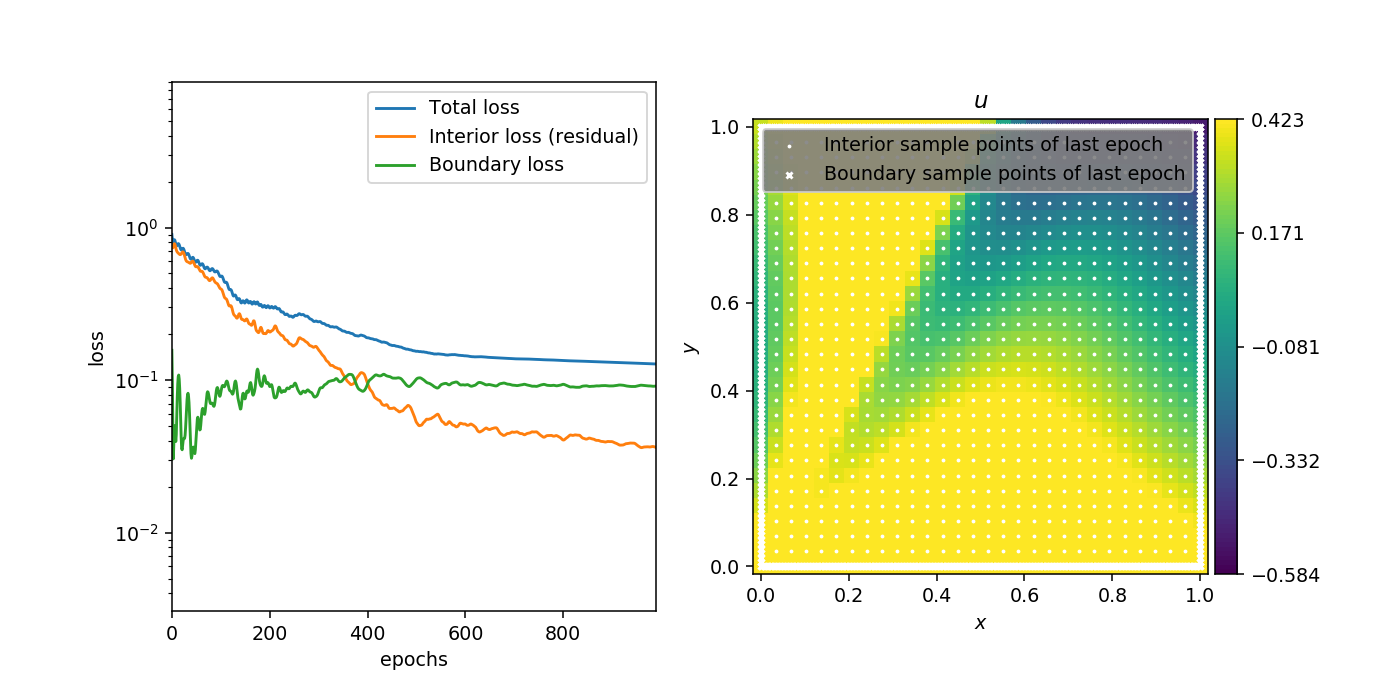

C:\Users\Bart de Koning\Anaconda3\lib\site-packages\ipykernel_launcher.py:243: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


No convergence after 999 epochs


In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1,
                                     beta_1=0.99,
                                     epsilon=1e-1) 

NN = PINN(optimizer,
          random_sampling      = False,
          hidden_layer_widths  = np.array([30,20,20]),
          interior_grid_size   = 30,
          samples_per_boundary = [100,100,300,200],
          boundary_weight      = 0.5)

NN.fit(tf_epochs     = 1000,
       plot_interval = 10,
       eps           = 1e-6)

## Random interior sampling (small perturbation of grid, boundary avoiding)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1,
                                     beta_1=0.99,
                                     epsilon=1e-1) 

NN = PINN(optimizer,
          random_sampling      = True,
          hidden_layer_widths  = np.array([40,40,40]),
          interior_grid_size   = 30,
          samples_per_boundary = [100,100,300,200],
          boundary_weight      = 0.5)

NN.fit(tf_epochs     = 1000,
       plot_interval = 25,
       eps           = 1e-6)